# ATLAS RPV CNN Classifier

Mostly taken from Michela's Keras implementation here: https://github.com/mickypaganini/susy_rpv/blob/micky/train.py

In [1]:
# GPU selection
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from __future__ import print_function
from __future__ import division

import h5py
import numpy as np

from keras import layers, models, callbacks
from keras import backend as K

from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


## Global configuration

In [3]:
# Data config
n_train = 64000 #412416
n_valid = 32000 #137471
n_test = 32000 #137471

## Load the data

In [4]:
input_dir = '/data0/atlas-rpv-images'

In [5]:
ls -lh $input_dir

total 1.8G
-rw-rw---- 1 sfarrell sfarrell 358M May  1 20:52 test.h5
-rw-rw---- 1 sfarrell sfarrell 1.1G May  1 20:52 train.h5
-rw-rw---- 1 sfarrell sfarrell 358M May  1 20:52 val.h5


In [6]:
def load_file(file, n_samples):
    print('Loading file', file)
    with h5py.File(file) as f:
        data_group = f['all_events']
        print('Loading %i/%i events' %
              (n_samples, data_group['hist'].shape[0]))
        data = data_group['hist'][:n_samples][:,:,:,None]
        labels = data_group['y'][:n_samples]
        weights = data_group['weight'][:n_samples]
    return data, labels, weights

In [7]:
%%time

train_file = os.path.join(input_dir, 'train.h5')
valid_file = os.path.join(input_dir, 'val.h5')
test_file = os.path.join(input_dir, 'test.h5')

train_input, train_labels, train_weights = load_file(train_file, n_train)
valid_input, valid_labels, valid_weights = load_file(valid_file, n_valid)
test_input, test_labels, test_weights = load_file(test_file, n_test)

Loading file /data0/atlas-rpv-images/train.h5
Loading 64000/412416 events
Loading file /data0/atlas-rpv-images/val.h5
Loading 32000/137471 events
Loading file /data0/atlas-rpv-images/test.h5
Loading 32000/137471 events
CPU times: user 12.2 s, sys: 1.72 s, total: 13.9 s
Wall time: 14 s


In [8]:
print('train shape:', train_input.shape)
print('valid shape:', valid_input.shape)
print('test shape: ', test_input.shape)

train shape: (64000, 64, 64, 1)
valid shape: (32000, 64, 64, 1)
test shape:  (32000, 64, 64, 1)


## Define the model

In [9]:
def build_model(input_shape, optimizer='Nadam',
                h1=64, h2=128, h3=256, h4=256, h5=512):
    inputs = layers.Input(shape=input_shape)
    h = layers.Conv2D(h1, kernel_size=(3, 3), activation='relu', strides=1, padding='same')(inputs)
    h = layers.Conv2D(h2, kernel_size=(3, 3), activation='relu', strides=2, padding='same')(h)
    h = layers.Conv2D(h3, kernel_size=(3, 3), activation='relu', strides=1, padding='same')(h)
    h = layers.Conv2D(h4, kernel_size=(3, 3), activation='relu', strides=2, padding='same')(h)
    h = layers.Flatten()(h)
    h = layers.Dense(h5, activation='relu')(h)
    outputs = layers.Dense(1, activation='sigmoid')(h)
    model = models.Model(inputs, outputs, 'RPVClassifier')
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## Train the model

In [10]:
# Model config
h1, h2, h3, h4, h5 = 64, 128, 256, 256, 512
optimizer = 'Adam'

In [11]:
# Training config
batch_size = 256
n_epochs = 16
use_weights = False

In [ ]:
model = build_model(train_input.shape[1:],
                    h1=h1, h2=h2, h3=h3, h4=h4, h5=h5,
                    optimizer=optimizer)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               33554944  
__________

In [ ]:
fit_args = dict(x=train_input, y=train_labels,
                batch_size=batch_size, epochs=n_epochs,
                validation_data=(valid_input, valid_labels))
if use_weights:
    fit_args.update(sample_weight=train_weights,
                    validation_data=(valid_input, valid_labels, valid_weights))
history = model.fit(**fit_args)

Train on 64000 samples, validate on 32000 samples
Epoch 1/16
64000/64000 [==============================] - 44s 685us/step - loss: 0.2726 - acc: 0.8824 - val_loss: 0.2295 - val_acc: 0.9082

<IPython.core.display.Javascript object>


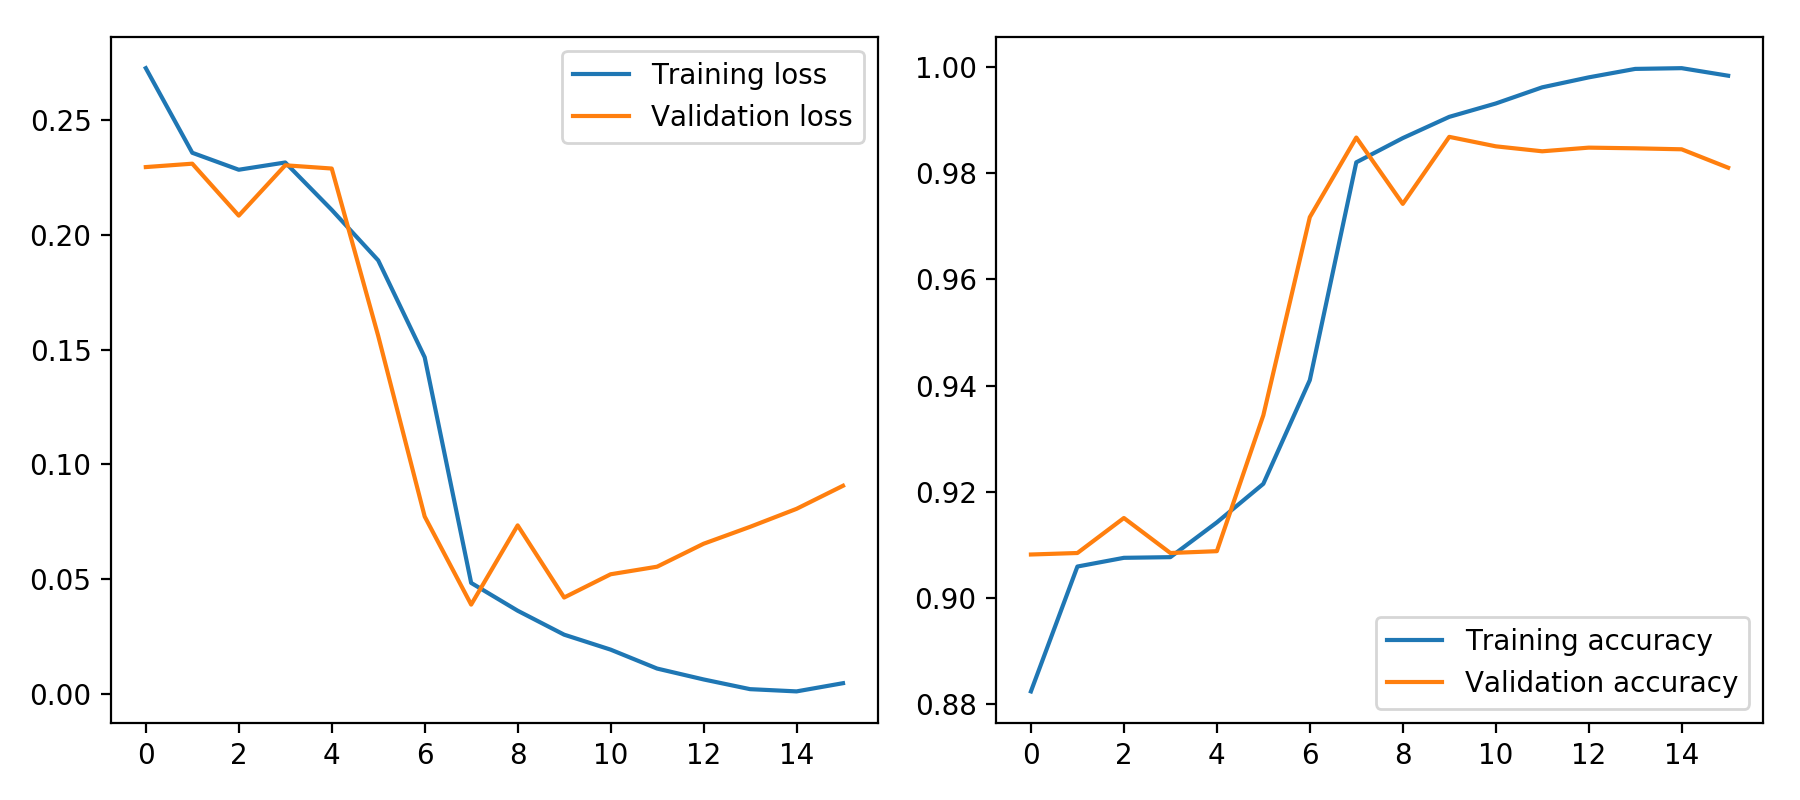

In [21]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend(loc=0)
plt.subplot(122)
plt.plot(history.epoch, history.history['acc'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_acc'], label='Validation accuracy')
plt.legend(loc=0)
plt.tight_layout()

## Evaluate on the test set

In [22]:
def summarize_metrics(labels, outputs, threshold=0.5, weights=None):
    preds = outputs > threshold
    print('Metrics summaries with threshold of %.3f' % threshold)
    print('Accuracy:   %.4f' % metrics.accuracy_score(labels, preds, sample_weight=weights))
    print('Purity:     %.4f' % metrics.precision_score(labels, preds, sample_weight=weights))
    print('Efficiency: %.4f' % metrics.recall_score(labels, preds, sample_weight=weights))

def draw_roc(labels, outputs, weights=None, ax=None):
    fpr, tpr, _ = metrics.roc_curve(labels, outputs, sample_weight=weights)
    auc = metrics.roc_auc_score(labels, outputs, sample_weight=weights)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='CNN, AUC=%.3f' % auc)
    ax.plot([0, 1], [0, 1], '--', label='Random')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(loc=0)

In [23]:
test_output = model.predict(test_input)
test_output = test_output.squeeze(-1)

In [24]:
# Unweighted results
summarize_metrics(test_labels, test_output)

Metrics summaries with threshold of 0.500
Accuracy:   0.9805
Purity:     0.9837
Efficiency: 0.9704


In [25]:
# Weighted results
summarize_metrics(test_labels, test_output, weights=test_weights, threshold=0.999)

Metrics summaries with threshold of 0.999
Accuracy:   0.9972
Purity:     0.0185
Efficiency: 0.8452


<IPython.core.display.Javascript object>


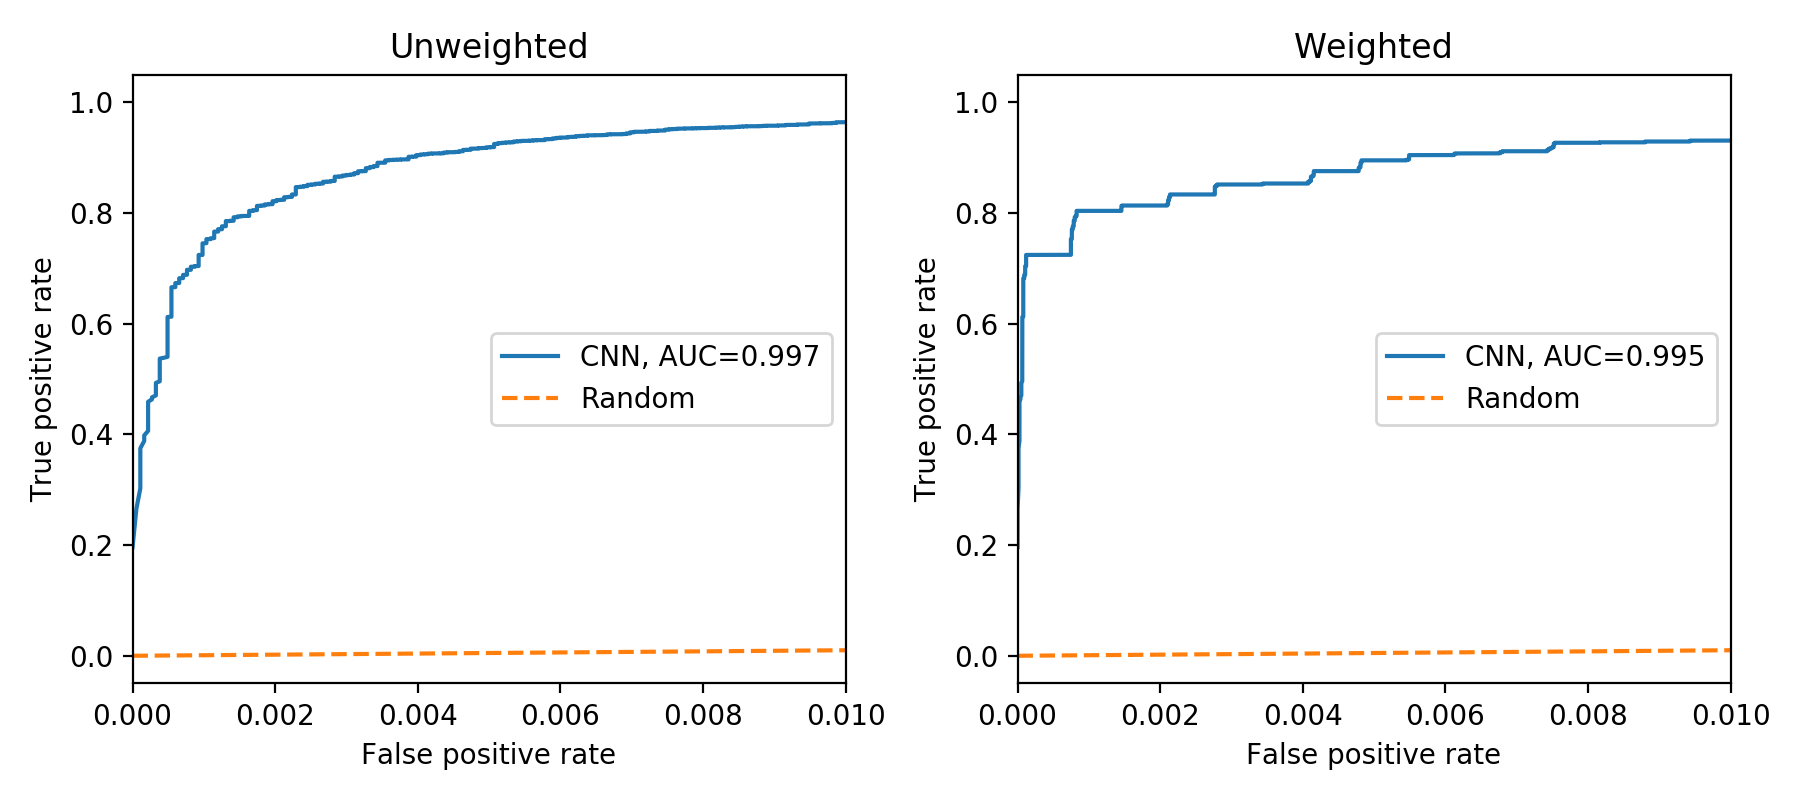

In [26]:
# Draw the ROC curve
fig, axs = plt.subplots(1, 2, figsize=(9,4))
draw_roc(test_labels, test_output, ax=axs[0])
draw_roc(test_labels, test_output, ax=axs[1], weights=test_weights)
axs[0].set_xlim([0, 0.01])
axs[0].set_title('Unweighted')
axs[1].set_xlim([0, 0.01])
axs[1].set_title('Weighted')
plt.tight_layout()

<IPython.core.display.Javascript object>


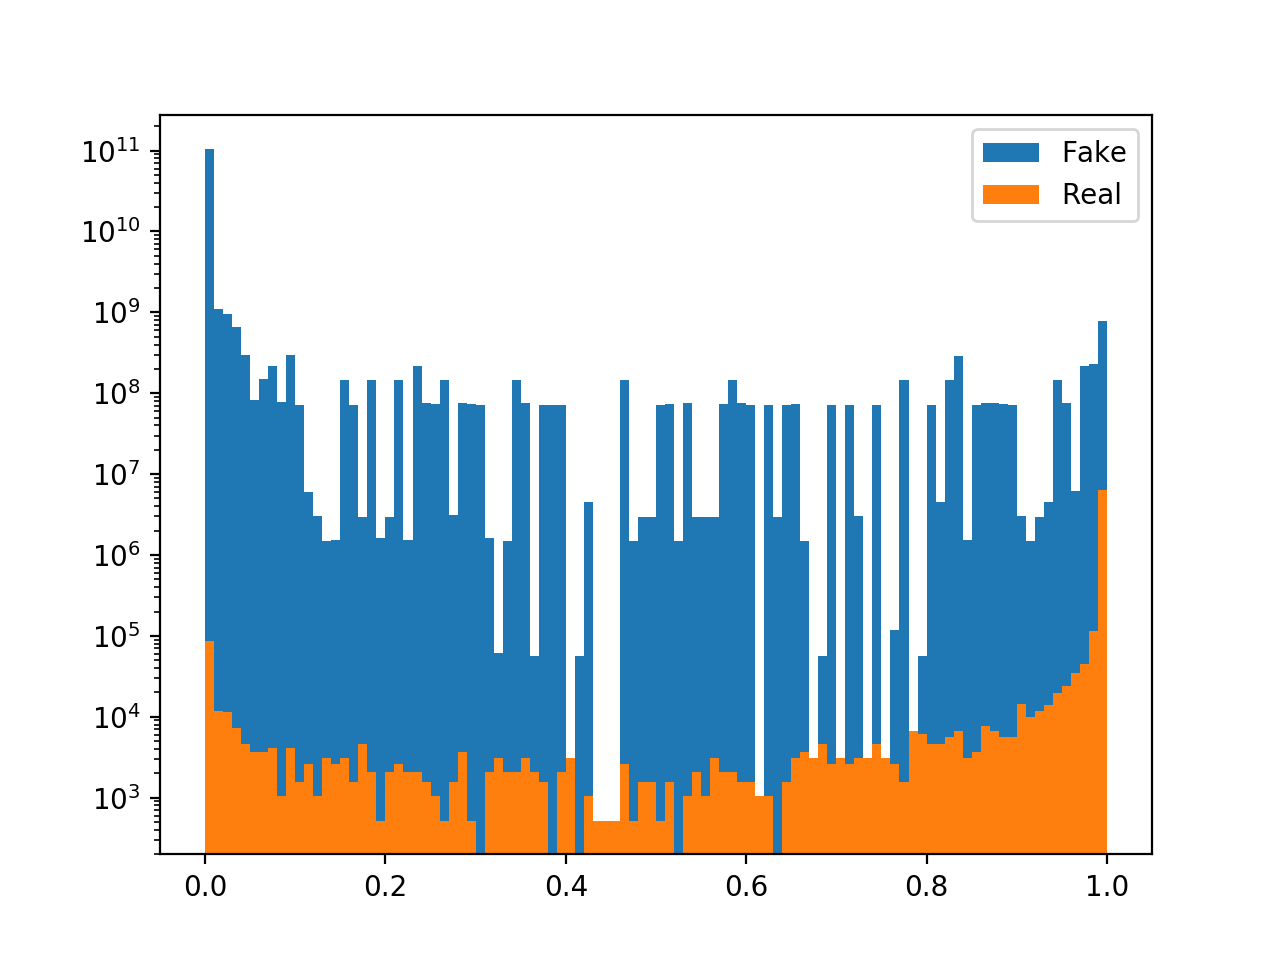

In [27]:
# Visualize the model output
plt.figure()

# Select real/fake sample model outputs
real_idx = test_labels > 0.5
fake_idx = (real_idx == False)

binning=dict(bins=100, range=(0, 1), log=True)
plt.hist(test_output[fake_idx], weights=test_weights[fake_idx], label='Fake', **binning)
plt.hist(test_output[real_idx], weights=test_weights[real_idx], label='Real', **binning)
plt.legend(loc=0);